# Solución a la tarea 1 de estadística 3

Solución de la tarea 1. El PDF que está adjunto en la carpeta llamada **doc** que hace parte de la carpeta llamada **tarea 1**.

#Punto 1
1. Utilizas el siguiente set de datos para calcular paso por paso (mostrar
procedimiento y fórmulas):

**Nota:** Decidí organizarlo de menor a mayor usando la variable "Initial Label", también se señalaron los datos que se van a usar para el entrenamiento y que asi sea más fácil diferenciar el entrenamiento de las pruebas.
![Datos Punto 1](DatosPunto1.png)


**1.1** ¿Cuál es la media, mediana y desviación estándar?, y la moda y los valores repeticiones de la moda para los datos categóricos. (Media, mediana, moda, frecuencia moda, desviación estándar)  
**1.2** Dibujar un boxplot a mano. Utilizando los datos de la tabla 1 y las siguientes proporciones. (Mínimo, Q1, Q2, Q3, máximo, IQR, limite inferior, limite superior)  
**1.3** ¿Cuál es la covarianza entre las 2 variables X(GDP), Y(Population)? ((Xi-X̂), (Yi-Ŷ), (Xi-X̂)/DESVESTA, (Yi-Ŷ)/DESVESTA, Covarianza, dato obtenido en la covarianza)  
**1.4** ¿Cuál es la correlación entre la variable  X(GDP), Y(Population)? (Denominador de X, Denominador de Y, Denominador total, dato obtenido en r)  
**1.5** Explica la relación entre covarianza y correlación.

**Las respuestas de los anteriores puntos están en un archivo de excel llamado "Tarea1_Punto1_KOMM.xlsx" que se encuentra en la carpeta llamada doc que hace parte de la carpeta llamada tarea 1.** El archivo tiene comentarios en varias partes, en las preguntas de este archivo indiqué entre paréntesis los datos que están comentados en sus respectivos puntos.


In [17]:
# Importamos las librerías necesarias. Estas librerias no serán usadas para el punto 1.6
import os
import re
import math
import random
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from scipy import stats
from os.path import isfile
import plotly.express as px
from collections import Counter
import matplotlib.pyplot as plt
import scipy.spatial.distance as ssd
import scipy.cluster.hierarchy as sch
from sklearn.decomposition import PCA
from urllib.request import urlretrieve
from sklearn.impute import SimpleImputer
from scipy.stats import shapiro, normaltest
from openpyxl import Workbook, load_workbook
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from openpyxl.utils.dataframe import dataframe_to_rows

**1.6** Calcule el resultado del algoritmo K-means sobre este set de datos a mano como lo hicimos en excel o con python sin utilizar librerías. Vamos a
crear 4 grupos, es decir, k=4 ( clusters).

In [ ]:
#Subir el archivo a google colab
from google.colab import files
uploaded = files.upload()

Saving Data1.xlsx to Data1 (1).xlsx


In [ ]:
# Cargar los datos originales
df = pd.read_excel('Data1.xlsx')

# Filtrar datos de entrenamiento y prueba
train_data = df[df["Label"] == "Yes"].drop(columns=["Label"])
test_data = df[df["Label"] == "No"].drop(columns=["Label"])

# Guardar en archivos separados
train_data.to_excel("train.xlsx", index=False)
test_data.to_excel("test.xlsx", index=False)

In [ ]:
#Descargar los archivos
files.download("train.xlsx")
files.download("test.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Fase de entrenamiento

In [ ]:
# Cargar los datos
df = pd.read_excel("train.xlsx")

# Filtrar solo columnas numéricas
columnas_numericas = df.select_dtypes(include=['number']).columns

# Distancia euclidiana entre dos puntos
def distancia_euclidiana(a, b):
    return math.sqrt(sum((x - y) ** 2 for x, y in zip(a, b)))

# Asignar cada punto al centroide más cercano
def asignarClusters(datos, centroides):
    clusters = []
    distancias = []
    for punto in datos:
        distanciasACentroides = [distancia_euclidiana(punto, centroide) for centroide in centroides]
        distancias.append(distanciasACentroides)
        clusters.append(distanciasACentroides.index(min(distanciasACentroides)))
    return clusters, distancias

# Recalcular centroides
def actualizarCentroides(datos, clusters, k):
    nuevosCentroides = []
    for i in range(k):
        puntosEnCluster = [datos[j] for j in range(len(datos)) if clusters[j] == i]
        if puntosEnCluster:
            nuevoCentroide = np.mean(puntosEnCluster, axis=0)
            nuevosCentroides.append(nuevoCentroide)
        else:
            nuevosCentroides.append(random.choice(datos))
    return nuevosCentroides

# Guardar resultados en Excel
def guardarResultadosEnExcel(df, centroides, distancias, clusters, iteracion, nombreArchivo='kmeans_manual.xlsx'):
    df_iteracion = df.copy()
    for i, _ in enumerate(centroides):
        df_iteracion[f'dist_C{i}'] = [dist[i] for dist in distancias]
    df_iteracion['Cluster'] = clusters

    dfCentroides = pd.DataFrame(centroides, columns=columnas_numericas)

    # Cargar o crear el archivo Excel
    if iteracion == 0:
        libro = Workbook()
        hoja = libro.active
        hoja.title = "Resultados KMeans"
    else:
        libro = load_workbook(nombreArchivo)
        hoja = libro.active

    hoja.append([f"Iteración {iteracion}"])
    hoja.append([])

    # Agregar encabezados en cada iteración
    for fila in dataframe_to_rows(df_iteracion, index=False, header=True):
        hoja.append(fila)

    hoja.append([f"Centroides Iteración {iteracion}"])
    hoja.append([])

    for fila in dataframe_to_rows(dfCentroides, index=False, header=True):
        hoja.append(fila)

    libro.save(nombreArchivo)
    libro.close()

# Guardar centroides finales
def guardarCentroidesFinales(centroides, nombreArchivo='centroides_finales.xlsx'):
    dfCentroides = pd.DataFrame(centroides, columns=columnas_numericas)
    dfCentroides.to_excel(nombreArchivo, index=False)

# Implementar K-Means manual
def kmeansManual(datos, df, k, maxIteraciones=100, nombreArchivo='kmeans_manual.xlsx'):
    centroides = df.groupby("Initial Label")[columnas_numericas].mean().values

    for iteracion in range(maxIteraciones):
        clusters, distancias = asignarClusters(datos, centroides)
        nuevosCentroides = actualizarCentroides(datos, clusters, k)

        guardarResultadosEnExcel(df, centroides, distancias, clusters, iteracion, nombreArchivo)

        if np.allclose(centroides, nuevosCentroides):
            print(f"Convergencia alcanzada en la iteración {iteracion}")
            break

        centroides = nuevosCentroides

    # Guardar los centroides finales en un archivo Excel
    guardarCentroidesFinales(centroides)

# Ejecutar el algoritmo con k=4
k = 4
datos_numericos = df[columnas_numericas].values
kmeansManual(datos_numericos, df, k)


Convergencia alcanzada en la iteración 4


In [ ]:
# Descargar los archivos
files.download("kmeans_manual.xlsx")
files.download("centroides_finales.xlsx")

#Fase de pruebas.
El código implementado aqui será el que me ayudará a corroborar si el modelo está bien y subiendo el archivo generado a la plataforma kaggle

In [ ]:
# Función para calcular la distancia euclidiana
def distancia_euclidiana(p1, p2):
    return np.linalg.norm(np.array(p1) - np.array(p2))

# Función para normalizar los datos usando Min-Max
def normalizacionMinMax(datos):
    datos_normalizados = []
    for caracteristica in datos.T:
        valor_minimo = min(caracteristica)
        valor_maximo = max(caracteristica)
        if valor_maximo - valor_minimo == 0:
            caracteristica_normalizada = [0] * len(caracteristica)
        else:
            caracteristica_normalizada = [(x - valor_minimo) / (valor_maximo - valor_minimo) for x in caracteristica]
        datos_normalizados.append(caracteristica_normalizada)
    return np.array(datos_normalizados).T

# Cargar centroides desde el archivo Excel
dfCentroidesFinales = pd.read_excel("centroides_finales.xlsx")
centroides = dfCentroidesFinales.values

# Cargar los datos de prueba
dfPrueba = pd.read_excel('test.xlsx')

# Definir las columnas numéricas utilizadas para K-Means
columnas_numericas = dfCentroidesFinales.columns  # Asegúrate de que estas sean las correctas
datosPrueba = dfPrueba[columnas_numericas].values

# Normalizar datos de prueba y centroides usando el mismo método
datosPruebaNormalizados = normalizacionMinMax(datosPrueba)
centroidesNormalizados = normalizacionMinMax(centroides)

# Cargar las ciudades del conjunto de entrenamiento
dfEntrenamiento = pd.read_excel("train.xlsx")  # Asegúrate de que este archivo es el correcto
ciudades = dfEntrenamiento['City'].values  # Suponiendo que la columna se llama 'City'

# Función para predecir el cluster más cercano y asignar el valor más común
def predecirCentroideMasCercano(datosPrueba, centroides, ciudades):
    predicciones = []

    for ciudad in datosPrueba:
        distancias = [distancia_euclidiana(ciudad, centroide) for centroide in centroides]
        indiceCentroideCercano = np.argmin(distancias)
        predicciones.append(ciudades[indiceCentroideCercano])

    # Encontrar el cluster más común y asignarlo a todas las filas
    cluster_mas_comun = Counter(predicciones).most_common(1)[0][0]

    return [cluster_mas_comun] * len(predicciones)  # Asigna el valor más común a todas las filas

# Hacer las predicciones para los datos de prueba
dfPrueba['etiqueta'] = predecirCentroideMasCercano(datosPruebaNormalizados, centroidesNormalizados, ciudades)

# El ID debe coincidir con los datos de prueba
dfPrueba['ID'] = dfPrueba['City']  # Asegurar que coincida con el formato de Kaggle

# Crear el archivo de salida para Kaggle
dfEnvio = dfPrueba[['ID', 'etiqueta']]
dfEnvio.to_csv('kmeans_Kevin_Orlando_Murcia_Morales.csv', index=False, encoding="utf-8-sig")

print("Proceso finalizado. Archivo 'kmeans_Kevin_Orlando_Murcia_Morales.csv' generado exitosamente.")


Proceso finalizado. Archivo 'kmeans_Kevin_Orlando_Murcia_Morales.csv' generado exitosamente.


In [ ]:
# Descargar los archivos
files.download("kmeans_Kevin_Orlando_Murcia_Morales.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print("Centroides finales:")
print(pd.DataFrame(centroidesNormalizados, columns=columnas_numericas))


Centroides finales:
        GDP  Population  Unemployment Rate  Average Age  Women (%)   Men (%)  \
0  0.029475    0.058996           0.228000     0.785714   0.600000  0.400000   
1  0.008060    0.022913           0.637143     0.285714   0.333333  0.666667   
2  1.000000    1.000000           0.050000     1.000000   0.666667  0.333333   
3  0.263294    0.278940           0.246667     0.714286   0.666667  0.333333   

     Budget  Initial Label  
0  0.045682       0.533333  
1  0.014326       0.619048  
2  1.000000       0.666667  
3  0.272052       0.888889  


In [ ]:
print(dfEnvio.head(10))  # Ver las primeras filas del archivo de salida


               ID etiqueta
0   Villavicencio  Armenia
1           Mocoa  Armenia
2  Puerto Carreño  Armenia
3          Cúcuta  Armenia
4           Pasto  Armenia
5     Bucaramanga  Armenia
6          Arauca  Armenia
7          Ibagué  Armenia
8        Riohacha  Armenia


#Punto 2
En este punto voy a usar los datos de entrenamiento y de prueba por aparte

##PCA. Utilizar los datos de la tabla 1, para calcular PCA y reducir la
dimensionalidad de 2 dimensiones a 1. Para este ejercicio se debe utilizar las
variables GDP (USD Billion) y Population (Millions) para crear un vector con una sola dimensión.

In [ ]:
# Cargar datos de entrenamiento y prueba
df_train = pd.read_excel("train.xlsx")
df_test = pd.read_excel("test.xlsx")

# Seleccionar las variables requeridas
columnas_pca = ['GDP', 'Population']

# Normalización con los datos de entrenamiento
scaler = StandardScaler()
train_scaled = scaler.fit_transform(df_train[columnas_pca])
test_scaled = scaler.transform(df_test[columnas_pca])
print("Datos normalizados (entrenamiento):")
print(pd.DataFrame(train_scaled, columns=columnas_pca).head())

print("\nDatos normalizados (prueba):")
print(pd.DataFrame(test_scaled, columns=columnas_pca).head())

# Aplicar PCA usando solo los datos de entrenamiento
pca = PCA(n_components=1)
train_pca = pca.fit_transform(train_scaled)
test_pca = pca.transform(test_scaled)

# Agregar la nueva dimensión a los DataFrames
df_train['PCA_1D'] = train_pca
df_test['PCA_1D'] = test_pca

# Mostrar los primeros valores de PCA
print("\nPCA reducido a 1D (entrenamiento):")
print(df_train[['PCA_1D']].head())

print("\nPCA reducido a 1D (prueba):")
print(df_test[['PCA_1D']].head())

# Guardar los resultados en nuevos archivos
df_train.to_excel("train_con_PCA.xlsx", index=False)
df_test.to_excel("test_con_PCA.xlsx", index=False)

print("\nProceso finalizado. Archivos 'train_con_PCA.xlsx' y 'test_con_PCA.xlsx' generados exitosamente.")



Datos normalizados (entrenamiento):
        GDP  Population
0 -0.395990   -0.382077
1 -0.439597   -0.478670
2 -0.029694    0.088007
3 -0.217203   -0.266166
4 -0.387269   -0.362759

Datos normalizados (prueba):
        GDP  Population
0 -0.334941   -0.253287
1 -0.452679   -0.549504
2 -0.461400   -0.568823
3 -0.265170   -0.085860
4 -0.348023   -0.285485

PCA reducido a 1D (entrenamiento):
     PCA_1D
0 -0.550177
1 -0.649313
2  0.041233
3 -0.341793
4 -0.530350

PCA reducido a 1D (prueba):
     PCA_1D
0 -0.415940
1 -0.708651
2 -0.728478
3 -0.248216
4 -0.447958

Proceso finalizado. Archivos 'train_con_PCA.xlsx' y 'test_con_PCA.xlsx' generados exitosamente.


In [ ]:
# Descargar los archivos
files.download("train_con_PCA.xlsx")
files.download("test_con_PCA.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##**2.1 ¿Cuál es la matriz de covarianza?**  
Solo usamos los datos de entrenamiento, ya que PCA debe entrenarse con esos datos.

In [ ]:
# Cargar los datos de entrenamiento
df_train = pd.read_excel("train.xlsx")

# Seleccionar las variables requeridas
columnas_pca = ['GDP', 'Population']

# Calcular la matriz de covarianza
covarianza = df_train[columnas_pca].cov()

print("Matriz de covarianza:")
print(covarianza)

Matriz de covarianza:
                   GDP  Population
GDP         552.182619   37.086017
Population   37.086017    2.532123


##**2.2 ¿Cuales son los eigenvalues?**  


In [ ]:
cov_array = covarianza.values

# Calcular eigenvalores y eigenvectores
eigenvalores, eigenvectores = np.linalg.eig(cov_array)

# Mostrar los eigenvalores
print("Eigenvalores:", eigenvalores)

Eigenvalores: [5.54673598e+02 4.11446693e-02]


Valor Alto (5.54673598e+02):
Este eigenvalor es significativamente mayor que el segundo eigenvalor. Indica que hay una dirección en los datos (representada por el correspondiente eigenvector) en la que hay una alta variabilidad. Esta dirección es la principal componente en PCA y explica la mayor parte de la varianza de los datos.

Valor Bajo (4.11446693e-02):
Este eigenvalor es muy pequeño en comparación con el primero. Indica que la varianza en esta dirección es mucho menor. La dirección correspondiente a este eigenvalor (su eigenvector) explica poca varianza en los datos.

##**2.3. Cuál es la varianza explicada por el eigenvalue**


In [ ]:
# Varianza total
varianza_total = np.sum(eigenvalores)

# Varianza explicada por cada componente
varianza_explicada = eigenvalores / varianza_total

print("Varianza total:", varianza_total)
print("Varianza explicada por cada componente:")
print(varianza_explicada)


Varianza total: 554.7147423809524
Varianza explicada por cada componente:
[9.99925827e-01 7.41726624e-05]


Estos resultados son indicativos de que el primer componente principal es muy significativo para representar la variabilidad en los datos, mientras que el segundo componente tiene una contribución menor.

##**2.4** ¿Cuál es el valor del eigenvector?  


In [ ]:
print(eigenvectores)

[[ 0.99775186 -0.0670166 ]
 [ 0.0670166   0.99775186]]


El primer eigenvector \([0.99775186, 0.0670166]\) indica que la primera componente principal está principalmente alineada con la variable **GDP**, ya que su valor elevado en la primera posición sugiere que esta variable tiene una mayor influencia en la dirección del componente. En contraste, el segundo eigenvector \([-0.0670166, 0.99775186]\) muestra que la segunda componente principal está alineada con la variable **Population**, evidenciado por su gran magnitud en la segunda posición. La pequeña magnitud del primer eigenvector en la segunda posición y la del segundo eigenvector en la primera posición revelan que cada componente tiene una contribución menor en la dirección de la variable opuesta, lo que confirma que el **GDP** es el factor dominante en la primera componente principal, mientras que la **población** influye más en la segunda componente.

##**2.5** ¿Cuál es la matriz proyectada?   

In [ ]:
# Calcular la matriz proyectada para los datos de entrenamiento
matriz_proyectada_train = np.dot(train_scaled, eigenvectores)

# Calcular la matriz proyectada para los datos de prueba
matriz_proyectada_test = np.dot(test_scaled, eigenvectores)

# Mostrar resultados
print("Matriz proyectada de entrenamiento:")
print(matriz_proyectada_train)

print("\nMatriz proyectada de prueba:")
print(matriz_proyectada_test)



Matriz proyectada de entrenamiento:
[[-0.42070568 -0.35468017]
 [-0.47068766 -0.44813316]
 [-0.02372944  0.08979866]
 [-0.23455217 -0.25101147]
 [-0.41070929 -0.33598957]
 [-0.42591966 -0.36723798]
 [-0.46284903 -0.46156769]
 [ 4.28798245  3.76940786]
 [ 0.54581018  0.82602533]
 [-0.34113075 -0.27612289]
 [-0.38291321 -0.24750042]
 [-0.43591605 -0.38592858]
 [-0.44242469 -0.41776147]
 [-0.46935767 -0.49340057]
 [-0.49413288 -0.53691455]
 [ 1.50462118  0.98106066]
 [ 0.25900627  0.1998882 ]
 [-0.32854503 -0.21888215]
 [-0.37334836 -0.23523485]
 [-0.40114445 -0.323724  ]
 [-0.47935406 -0.51209117]]

Matriz proyectada de prueba:
[[-0.35116247 -0.23027101]
 [-0.48848735 -0.51793172]
 [-0.49848374 -0.53662232]
 [-0.27032821 -0.06789618]
 [-0.36637284 -0.26151942]
 [-0.18237709 -0.18997583]
 [-0.48241027 -0.49252386]
 [-0.29330654 -0.21479502]
 [-0.45026332 -0.40432694]]


##**2.6** ¿Cuál es el error o diferencia entre la matriz proyectada?  


In [ ]:
# Calcular el error entre los datos normalizados y la matriz proyectada (entrenamiento)
error_train = train_scaled - matriz_proyectada_train

# Calcular el error entre los datos normalizados y la matriz proyectada (prueba)
error_test = test_scaled - matriz_proyectada_test

# Mostrar resultados
print("Error en datos de entrenamiento:")
print(error_train)

print("\nError en datos de prueba:")
print(error_test)


Error en datos de entrenamiento:
[[ 0.02471526 -0.02739689]
 [ 0.03109053 -0.03053642]
 [-0.00596465 -0.00179215]
 [ 0.01734924 -0.01515458]
 [ 0.02344021 -0.02676899]
 [ 0.02556857 -0.02771808]
 [ 0.03197324 -0.0299809 ]
 [-0.26225286  0.27889183]
 [-0.05658446  0.03472132]
 [ 0.01927173 -0.02224066]
 [ 0.01744748 -0.02510512]
 [ 0.02684362 -0.02834599]
 [ 0.02899158 -0.02871061]
 [ 0.03412121 -0.03034552]
 [ 0.03709307 -0.03190804]
 [-0.06912994  0.09862903]
 [-0.01397811  0.01690834]
 [ 0.01540735 -0.02152589]
 [ 0.01660398 -0.0244917 ]
 [ 0.02259671 -0.02615556]
 [ 0.03539626 -0.03097343]]

Error en datos de prueba:
[[ 0.01622144 -0.02301603]
 [ 0.03580821 -0.03157238]
 [ 0.03708326 -0.03220028]
 [ 0.00515791 -0.01796384]
 [ 0.0183498  -0.02396513]
 [ 0.01314154 -0.0117952 ]
 [ 0.0340918  -0.03122223]
 [ 0.01505423 -0.01917352]
 [ 0.02810887 -0.02926613]]


##**2.7** Pintar todas las ciudades en 1 dimensión  


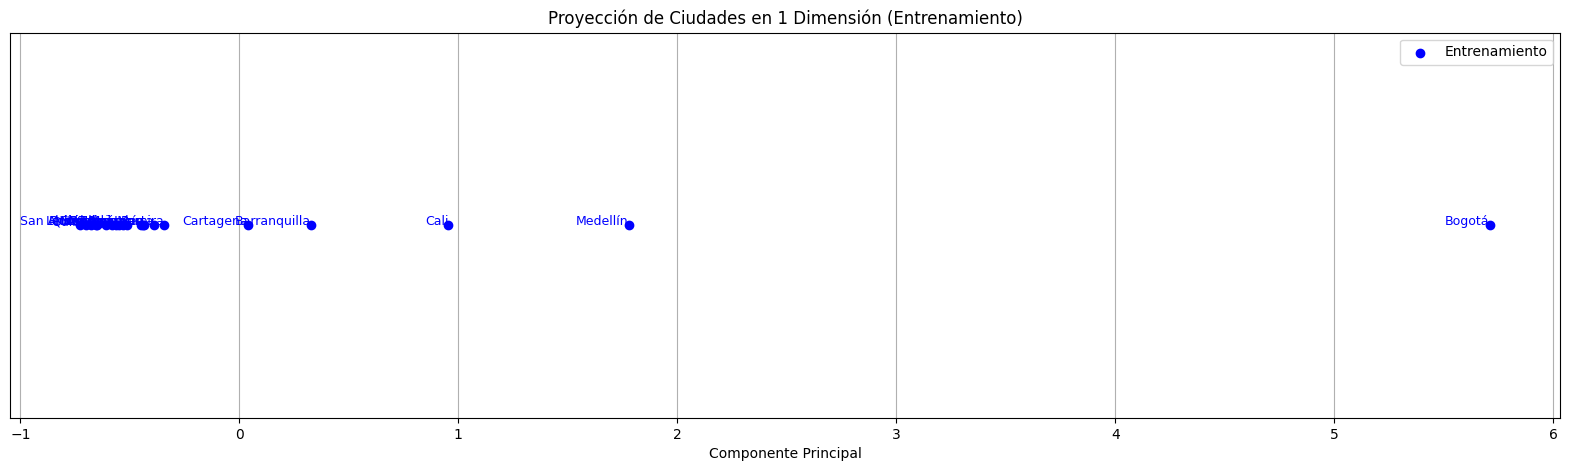

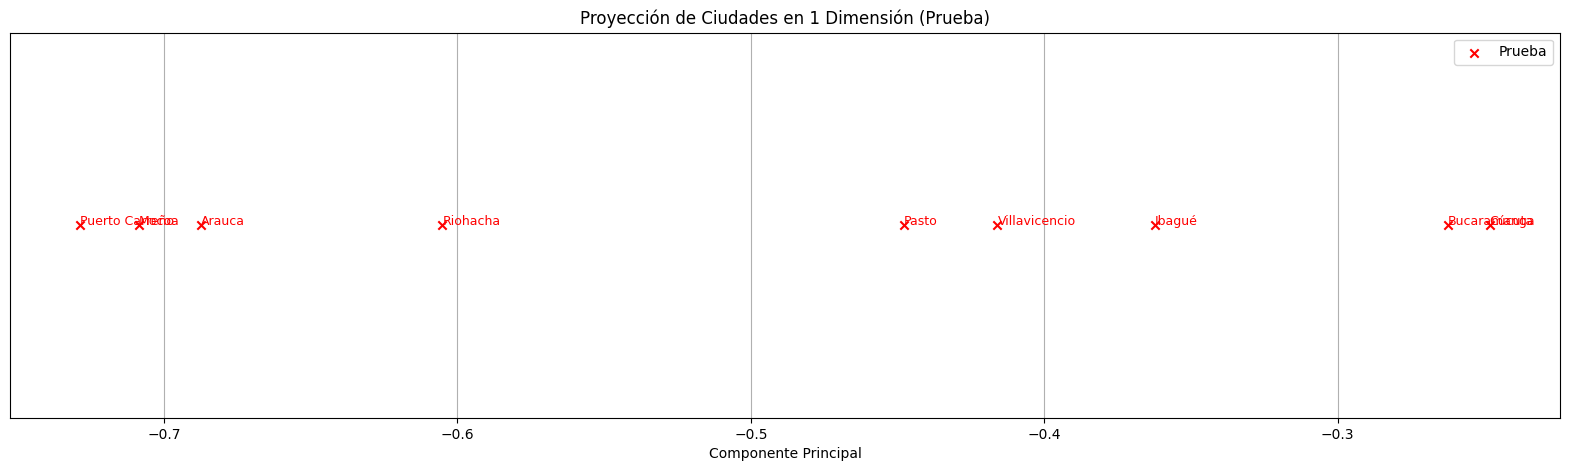

In [ ]:
# Extraer nombres de las ciudades desde los DataFrames
ciudades_train = df_train['City'].values
ciudades_test = df_test['City'].values

# Gráfico para datos de ENTRENAMIENTO
plt.figure(figsize=(20, 5))
plt.scatter(train_pca, [0] * len(train_pca), c='blue', marker='o', label="Entrenamiento")

for i, ciudad in enumerate(ciudades_train):
    plt.text(train_pca[i], 0, ciudad, fontsize=9, ha='right', color='blue')

plt.title('Proyección de Ciudades en 1 Dimensión (Entrenamiento)')
plt.xlabel('Componente Principal')
plt.yticks([])  # Eliminar eje Y
plt.grid(True)
plt.legend()
plt.show()

# Gráfico para datos de PRUEBA
plt.figure(figsize=(20, 5))
plt.scatter(test_pca, [0] * len(test_pca), c='red', marker='x', label="Prueba")

for i, ciudad in enumerate(ciudades_test):
    plt.text(test_pca[i], 0, ciudad, fontsize=9, ha='left', color='red')

plt.title('Proyección de Ciudades en 1 Dimensión (Prueba)')
plt.xlabel('Componente Principal')
plt.yticks([])  # Eliminar eje Y
plt.grid(True)
plt.legend()
plt.show()


##**2.8** Utilizar python para pintar todas las ciudades en 2 dimensiones

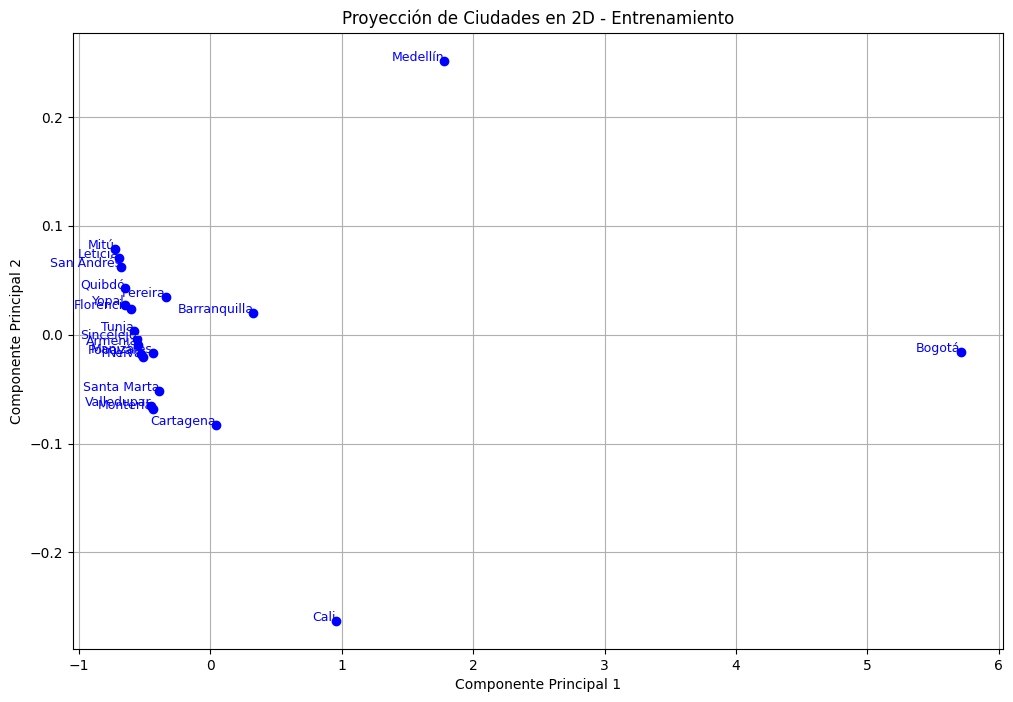

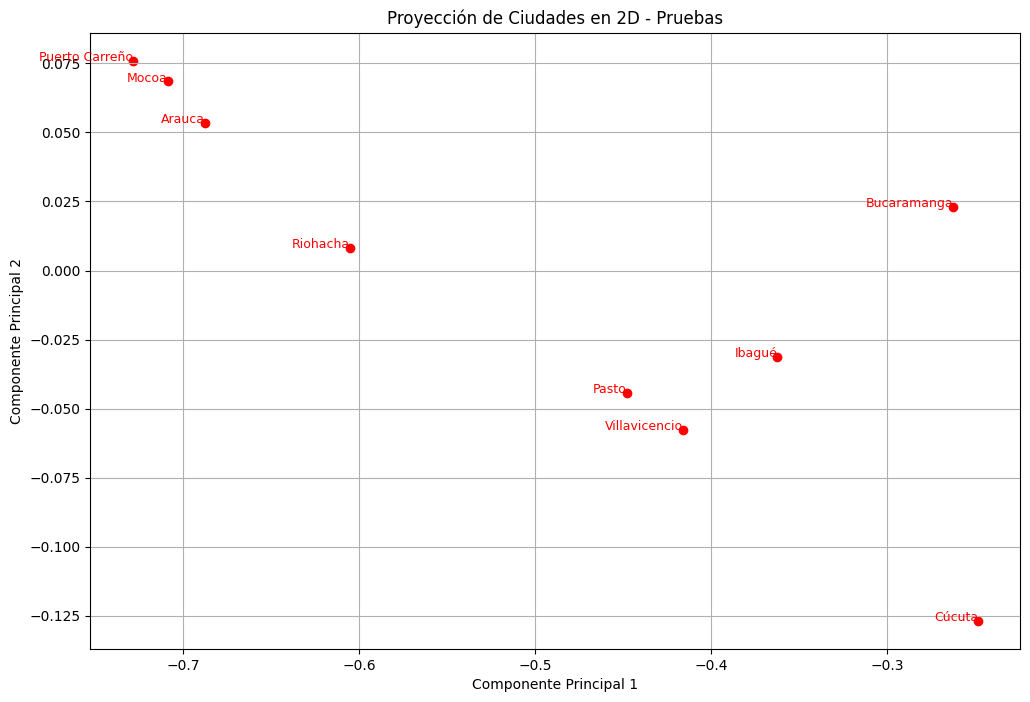

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Aplicar PCA para reducir a 2 dimensiones en entrenamiento y prueba
pca_2d = PCA(n_components=2)
train_pca_2d = pca_2d.fit_transform(train_scaled)  # Ajustar con entrenamiento
test_pca_2d = pca_2d.transform(test_scaled)  # Transformar los datos de prueba

# Extraer nombres de las ciudades
ciudades_train = df_train['City'].values
ciudades_test = df_test['City'].values

# Gráfico para datos de entrenamiento
plt.figure(figsize=(12, 8))
plt.scatter(train_pca_2d[:, 0], train_pca_2d[:, 1], c='blue', marker='o', label="Entrenamiento")
for i, ciudad in enumerate(ciudades_train):
    plt.text(train_pca_2d[i, 0], train_pca_2d[i, 1], ciudad, fontsize=9, ha='right', color='blue')

plt.title('Proyección de Ciudades en 2D - Entrenamiento')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.grid(True)
plt.show()

# Gráfico para datos de prueba
plt.figure(figsize=(12, 8))
plt.scatter(test_pca_2d[:, 0], test_pca_2d[:, 1], c='red', marker='o', label="Pruebas")
for i, ciudad in enumerate(ciudades_test):
    plt.text(test_pca_2d[i, 0], test_pca_2d[i, 1], ciudad, fontsize=9, ha='right', color='red')

plt.title('Proyección de Ciudades en 2D - Pruebas')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.grid(True)
plt.show()


#Punto 3  


##Regression. Utiliza las variables GDP y Population para crear una regresión. X es la población, y es el GDP.

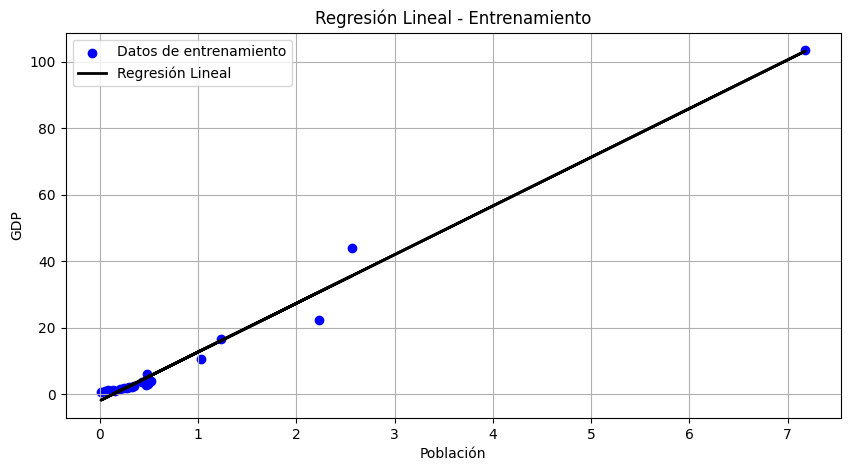

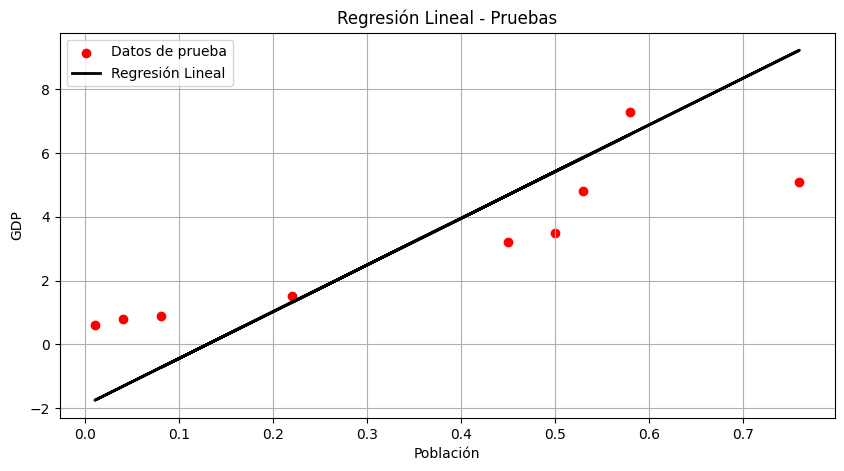

In [ ]:
# Extraer X (Population) y Y (GDP) para entrenamiento y prueba
X_train = df_train[['Population']].values
y_train = df_train[['GDP']].values

X_test = df_test[['Population']].values
y_test = df_test[['GDP']].values

# Crear y entrenar el modelo de regresión lineal con los datos de entrenamiento
modelo = LinearRegression()
modelo.fit(X_train, y_train)

# Hacer predicciones para los conjuntos de entrenamiento y prueba
y_pred_train = modelo.predict(X_train)
y_pred_test = modelo.predict(X_test)

# Gráfico para el conjunto de entrenamiento
plt.figure(figsize=(10, 5))
plt.scatter(X_train, y_train, color='blue', label='Datos de entrenamiento')
plt.plot(X_train, y_pred_train, color='black', linewidth=2, label='Regresión Lineal')
plt.xlabel('Población')
plt.ylabel('GDP')
plt.title('Regresión Lineal - Entrenamiento')
plt.legend()
plt.grid(True)
plt.show()

# Gráfico para el conjunto de prueba
plt.figure(figsize=(10, 5))
plt.scatter(X_test, y_test, color='red', label='Datos de prueba')
plt.plot(X_test, y_pred_test, color='black', linewidth=2, label='Regresión Lineal')
plt.xlabel('Población')
plt.ylabel('GDP')
plt.title('Regresión Lineal - Pruebas')
plt.legend()
plt.grid(True)
plt.show()


##3.1 Calcular b0, b1 sin librerías.

In [ ]:
# Función para calcular b0 y b1 sin librerías
def calcular_coeficientes(X, Y):
    n = len(X)
    x_mean = sum(X) / n
    y_mean = sum(Y) / n

    numerador = sum((X[i] - x_mean) * (Y[i] - y_mean) for i in range(n))
    denominador = sum((X[i] - x_mean) ** 2 for i in range(n))

    b1 = numerador / denominador
    b0 = y_mean - b1 * x_mean

    return b0, b1

# Extraer X (Population) y Y (GDP) para entrenamiento y prueba
X_train = df_train['Population'].values
y_train = df_train['GDP'].values
X_test = df_test['Population'].values
y_test = df_test['GDP'].values

# Calcular coeficientes para entrenamiento y prueba
b0_train, b1_train = calcular_coeficientes(X_train, y_train)
b0_test, b1_test = calcular_coeficientes(X_test, y_test)

# Imprimir coeficientes
print(f"Entrenamiento: b0 = {b0_train}, b1 = {b1_train}")
print(f"Prueba: b0 = {b0_test}, b1 = {b1_test}")


Entrenamiento: b0 = -1.902997540742673, b1 = 14.646212598912378
Prueba: b0 = 0.3627842306382658, b1 = 7.7081835723203795


Los coeficientes calculados representan la relación entre la **población (X)** y el **GDP (Y)** en los conjuntos de entrenamiento y prueba.

- **Para el entrenamiento:**  
  - \( b_0 = -1.90 \)  
  - \( b_1 = 14.64 \)  
  Esto significa que, en promedio, por cada unidad adicional de población, el GDP aumenta en **14.64** unidades. El valor negativo de \( b_0 \) indica que, con una población cercana a cero, el modelo predice un GDP negativo (lo cual no es realista, pero es común en regresiones lineales).  

- **Para la prueba:**  
  - \( b_0 = 0.36 \)  
  - \( b_1 = 7.71 \)  
  Aquí, el GDP crece en **7.71** unidades por cada unidad de población. El menor valor de \( b_1 \) comparado con el entrenamiento sugiere que la relación entre población y GDP en los datos de prueba es más débil o menos pronunciada.  

En resumen, la pendiente (\( b_1 \)) muestra que en ambos casos hay una relación positiva entre población y GDP, pero con diferente intensidad.


##3.2 Graficar la línea y los puntos

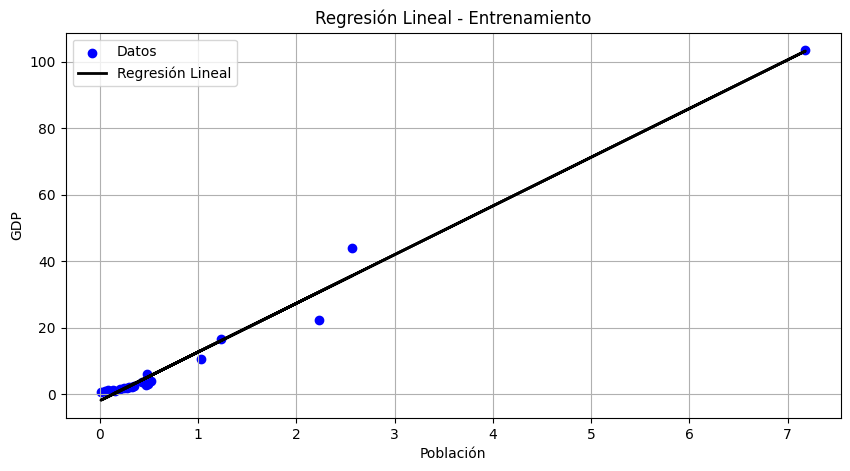

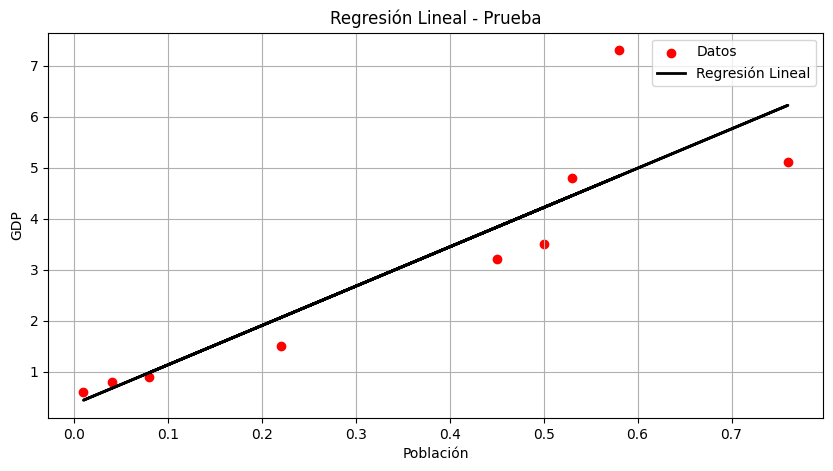

In [ ]:
# Función para graficar los datos y la recta de regresión
def graficar_regresion(X, Y, b0, b1, titulo, color):
    plt.figure(figsize=(10, 5))
    plt.scatter(X, Y, color=color, label='Datos')
    plt.plot(X, b0 + b1 * X, color='black', linewidth=2, label='Regresión Lineal')
    plt.xlabel('Población')
    plt.ylabel('GDP')
    plt.title(titulo)
    plt.legend()
    plt.grid(True)
    plt.show()

# Graficar para entrenamiento
graficar_regresion(X_train, y_train, b0_train, b1_train, "Regresión Lineal - Entrenamiento", 'blue')

# Graficar para prueba
graficar_regresion(X_test, y_test, b0_test, b1_test, "Regresión Lineal - Prueba", 'red')


#Punto 4

##Cargar el data set de caras que está en la carpeta datos de la tarea 2 (ver notebook)
https://github.com/jdramirez/UCO_ML_AI/blob/master/src/notebook/PCA.ipynb:

Carpeta '/data' creada exitosamente.


In [77]:
def download_files():
    """
    Este método descarga los archivos de imágenes si no existen.
    """
    # Crear la carpeta 'data' si no existe
    if not os.path.exists("data"):
        os.makedirs("data")

    path_tar = os.path.join("data", 'faces.zip')
    if not isfile(path_tar):
        urlretrieve(
            'http://courses.media.mit.edu/2002fall/mas622j/proj/faces/rawdata.zip',
            path_tar)
    dest_path = "data/faces"
    with zipfile.ZipFile(path_tar) as tar:
        tar.extractall(dest_path)
        tar.close()

download_files()

entrenamiento = [1855,4729,3954,2886,3168,4943,2288,2872,5059,2618,3365,1432,5092,4140,1600,4372,3157,2085,1264,
                4716,3533,3701,4524,1290,2415,2627,3391,2243,4988,5066,4386,2071,2875,2049,4944,4178,3953,2881,
                1638,1852,3739,4381,3998,2076,3396,2244,5061,2620,1899,1297,2412,3706,4523,1263,4711,3534,1607,
                4375,3150,2082,3362,1435,5095,4147,4986,5068,4388,2843,3991,2629,1890,4718,1864,4972,3965,3159,
                2616,2424,2040,3192,4185,5057,2272,2888,3166,1631,4343,1403,4171,2286,3354,4515,3730,3502,1255,
                4727,1609,3962,4975,4149,3708,1863,1897,1299,2844,3996,2078,3398,4981,3505,1252,4720,4512,3737,
                1404,4176,2281,3353,3161,1636,4344,4182,5050,2275,2047,3195,2423,2611,3763,4546,4774,3551,2483,
                4310,1662,3135,3909,3307,4122,1450,1696,2013,2221,3797,2645,4780,2477,4921,3338,3936,1239,1837,
                4579,2448,2810,5209,4787,2470,3790,2642,2226,5003,1691,2014,2828,3300,4125,4919,1457,4317,1665,
                3132,4773,3556,2484,3764,4541,2817,2219,1830,2689,3569,3931,4328,4926,1468,5035,1495,2210,2022,
                5207,2446,3594,4583,2674,3560,4745,1237,4577,1839,2680,3752,4113,1461,3336,3104,3938,4321,1653,
                3799,2479,1698,2821,3907,3309,4910,4548,1806,3103,4326,1654,4114,1466,4928,3331,4570,2687,3755,
                3567,4742,1230,4584,2673,2441,3593,2025,2819,5200,5032,1492,2217,3558,1801,1459,4917,4319,3900,
                2228,2826,4789,1298,1896,3399,4980,2079,2845,3997,4148,4974,1608,3963,3709,1862,2046,3194,4183,
                5051,2274,2610,2422,4513,3736,3504,4721,1253,3160,4345,1637,4177,1405,2280,3352,1865,4719,3158,
                3964,4973,4389,2842,3990,5069,4987,2628,1891,4170,1402,2287,3355,3167,2889,4342,1630,3503,4726,
                1254,4514,3731,2425,2617,4184,5056,2273,2041,3193,3952,2880,1639,4179,4945,1853,3738,2048,2874,
                4710,1262,3535,3707,4522,3363,5094,4146,1434,4374,1606,3151,2083,3397,2245,5060,4380,2077,3999,
                1296,2413,2621,1898,5058,2873,2619,4728,1854,4942,2289,3169,3955,2887,2626,1291,2414,4387,2070,
                3390,2242,5067,4989,4373,1601,3156,2084,3364,5093,4141,1433,3700,4525,4717,1265,3532,2440,3592,
                4585,2672,1493,5033,2216,2818,2024,5201,1467,4929,4115,3330,3102,1655,4327,3566,1231,4743,4571,
                2686,3754,2827,2229,4788,1800,3559,4318,3901,1458,4916,4576,1838,2681,3753,3561,1236,4744,3939,
                3105,1652,4320,1460,4112,3337,2023,5206,1494,5034,2211,4582,2675,2447,3595,3308,4911,3906,4549,
                1807,2478,3798,1699,2820,1664,4316,3133,3301,4918,1456,4124,3765,4540,4772,3557,2485,3791,2643,
                4786,2471,1690,2829,2015,2227,5002,3568,1831,2688,4927,1469,3930,4329,2218,2816,2220,5005,1697,
                2012,4781,2476,3796,2644,4775,3550,2482,3762,1809,4547,3306,1451,4123,1663,4311,3908,3134,2449,
                2811,5208,3937,4920,3339,1836,4578,1238,1944,4638,3079,2997,3845,4852,2399,2963,5148,2709,3274,
                4051,5183,1523,4263,1711,2194,3046,4607,1375,3422,3610,4435,1381,2504,2736,2352,3280,5177,4899,
                4297,2160,2158,2964,4069,4855,2990,3842,1729,1943,3628,4290,2167,3889,2355,3287,5170,2731,1988,
                1386,2503,3617,4432,4600,1372,3425,4264,1716,2193,3041,3273,5184,1524,5179,4897,4299,3880,2952,
                2738,1981,4609,1975,4863,3048,3874,2707,2535,3083,2151,5146,4094,2363,3077,2999,4252,1720,4060,
                1512,3245,2397,4404,3621,3413,4636,1344,1718,3873,4058,4864,3619,1972,1986,1388,2169,3887,2955,
                3289,4890,3414,4631,1343,4403,3626,4067,1515,3242,2390,3070,4255,1727,5141,4093,2364,3084,2156,
                2532,2700,3672,4457,1919,1317,4665,2592,3440,1773,4201,3818,3024,3216,1541,4033,1787,2102,2330,
                5115,2754,3686,4691,2566,4830,3229,3827,1328,4468,1926,2559,2901,4696,2561,2753,3681,2337,5112,
                1780,2939,2105,3211,1546,4808,4034,1774,4206,3023,1310,4662,2595,3447,3675,4450,2906,2308,1921,
                2798,3478,3820,4239,1579,4837,1584,5124,2301,2133,3485,2557,4492,2765,3471,1326,4654,1928,4466,
                3643,2791,1570,4002,3227,3829,3015,1742,4230,3688,2568,1789,2930,3816,3218,4801,1917,4459,1319,
                3012,1745,4237,4839,1577,4005,3220,4461,3644,2796,3476,1321,4653,4495,2762,3482,2550,2908,2134,
                1583,5123,2306,3449,1910,4806,1548,4208,3811,2339,2937,4698,1389,1987,3288,4891,3886,2954,2168,
                4865,4059,1719,3872,3618,1973,3085,2157,5140,4092,2365,2701,2533,4402,3627,3415,1342,4630,3071,
                1726,4254,1514,4066,3243,2391,1974,4608,3875,3049,4862,4298,3881,2953,4896,5178,2739,1980,1513,
                4061,3244,2396,2998,3076,1721,4253,3412,1345,4637,4405,3620,2534,2706,5147,4095,2362,3082,2150,
                2991,3843,1728,4854,4068,1942,3629,2965,2159,1373,4601,3424,3616,4433,3272,1525,4057,5185,1717,
                4265,2192,3040,2354,3286,5171,4291,3888,2166,1387,2502,2730,1989,5149,2962,2708,4639,1945,4853,
                2398,2996,3844,3078,2737,1380,2505,4296,2161,2353,3281,4898,5176,1710,4262,2195,3047,3275,1522,
                4050,5182,3611,4434,1374,4606,3423,3483,2551,4494,2763,5122,1582,2307,2135,2909,4004,4838,1576,
                3221,3013,4236,1744,3477,4652,1320,4460,3645,2797,2936,2338,4699,1911,3448,4209,3810,4807,1549,
                1929,4467,3642,2790,3470,4655,1327,3014,3828,4231,1743,4003,1571,3226,2132,5125,1585,2300,4493,
                2764,3484,2556,3219,4800,3817,1318,1916,4458,2569,3689,1788,2931,4207,1775,3022,3210,4035,1547,
                4809,3674,4451,4663,1311,2594,3446,2752,3680,4697,2560,1781,2104,2938,2336,5113,3479,1920,2799,
                1578,4836,3821,4238,2309,2907,2331,5114,1786,2103,4690,2567,2755,3687,4664,1316,2593,3441,3673,
                4456,1918,3217,4032,1540,4200,1772,3025,3819,2558,2900,3826,4831,3228,4469,1927,1329,5109,2922,
                2748,4679,1905,4813,3038,3804,2777,4480,3497,2545,2121,2313,5136,1596,4222,1750,3007,3235,4010,
                1562,3651,2783,4474,4646,1334,3463,3803,1768,4028,4814,1902,3669,2589,2119,2925,4641,1333,3464,
                3656,2784,4473,3232,4017,1565,4225,1757,3000,2314,5131,1591,2126,3490,2542,2770,4487,1934,4648,
                3009,3835,4822,2913,5138,1598,2779,3499,4021,1553,3204,3036,4213,1761,2580,3452,4677,1305,4445,
                3660,2574,4683,2746,3694,5107,2322,2110,1795,4489,2128,2914,4019,4825,1759,3832,3658,1933,2117,
                1792,5100,2325,2741,3693,2573,4684,4442,3667,2587,3455,4670,1302,3031,4214,1766,4026,1554,3203,
                2371,5154,4086,3091,2143,2527,2715,1356,4624,3401,3633,4416,1958,3257,2385,1500,4072,1732,4240,
                3859,3065,1993,2518,3892,2940,4885,3866,2188,4871,3268,4429,1967,1369,1735,4247,3062,3250,2382,
                1507,4849,4075,3634,4411,1351,4623,3406,2712,2520,2978,3096,2144,2376,5153,4081,3439,1960,1538,
                4876,5198,3861,4278,4882,2349,3895,2947,1994,1969,4427,3602,3430,1367,4615,3868,2186,3054,1703,
                4271,1531,4043,5191,3266,2172,4285,5165,2340,3292,2724,2516,1393,3259,4840,2985,3857,1358,1956,
                4418,2529,4088,2971,2511,1394,2723,5162,2347,3295,2949,2175,4282,4878,1536,4044,5196,3261,2181,
                3053,1704,4276,3437,1360,4612,4420,3605,2976,3098,2378,1951,3408,4249,2982,3850,4847,1509,1758,
                3833,4824,4018,3659,1932,4488,2915,2129,2586,3454,1303,4671,4443,3666,1555,4027,3202,3030,1767,
                4215,5101,2324,2116,1793,2572,4685,2740,3692,1599,5139,2912,3498,2778,4649,1935,4823,3834,3008,
                2747,3695,2575,4682,2111,1794,5106,2323]

test_faces = [3037,1760,4212,1552,4020,3205,4444,3661,2581,3453,1304,4676,2924,2118,4815,4029,3802,1769,2588,
              1903,3668,2127,2315,1590,5130,2771,4486,3491,2543,3657,2785,4472,1332,4640,3465,1756,4224,3001,3233,
              1564,4016,1904,4678,3805,3039,4812,2923,5108,2749,3234,1563,4011,1751,4223,3006,1335,4647,3462,3650,
              2782,4475,3496,2544,2776,4481,2312,1597,5137,2120,2180,3052,4277,1705,4045,5197,4879,1537,3260,4421,
              3604,3436,4613,1361,2722,2510,1395,2174,2948,4283,5163,2346,3294,3409,1950,4846,1508,4248,2983,3851,
              2379,3099,2977,5164,2341,3293,2173,4284,2517,1392,2725,3431,4614,1366,1968,4426,3603,4042,5190,1530,
              3267,2187,3055,3869,4270,1702,2528,2970,4089,2984,3856,3258,4841,1957,4419,1359,2521,2713,2377,5152,
              4080,3097,2145,2979,3251,2383,4074,1506,4848,4246,1734,3063,4622,1350,3407,3635,4410,3894,2946,4883,
              2348,1995,1961,3438,3860,4279,5199,1539,4877,3632,4417,1959,4625,1357,3400,4241,1733,3064,3858,3256,
              2384,4073,1501,3090,2142,2370,5155,4087,2714,2526,4870,3269,2189,3867,1368,4428,1966,2519,1992,4884,
              3893,2941,5018,2833,2659,4768,1814,4902,3915,3129,2666,4591,2454,3586,5215,2030,2202,1487,5027,1641,
              4333,3116,3324,1473,4101,2692,3740,4565,1225,4757,3572,3912,1679,4905,4139,1813,3778,2498,2834,2008,
              4750,3575,2695,3747,4562,3323,1474,4106,1646,4334,3111,2205,1480,5020,5212,2037,2453,3581,2661,4596,
              1825,4759,3924,3118,4933,2802,1489,5029,2668,3588,1442,4130,3315,3127,1670,4302,3543,2491,4766,4554,
              3771,2465,4792,3785,2657,5016,2233,2001,1684,4598,2805,2039,4934,4108,1648,3923,3749,1822,2006,1683,
              5011]

print("Caras de entrenamiento:",len(entrenamiento))
print("Caras de prueba:",len(test_faces))

Caras de entrenamiento: 1300
Caras de prueba: 300


Utiliza solo las caras de entrenamiento para los siguientes puntos:
1. Calcular la mean face. Que es la cara con el promedio de los pixeles y visualizarla.

⚠ Archivo 2412 tiene un tamaño incorrecto (262144 bytes).


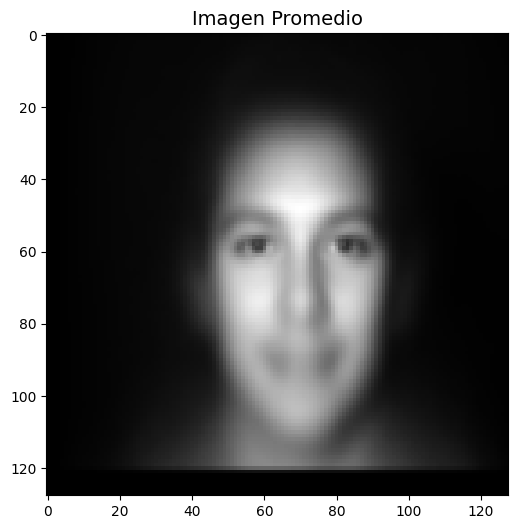

In [79]:
def cargar_imagenes_binarias(ruta, nombres):
    imagenes = []
    for nombre in nombres:
        ruta_completa = os.path.join(ruta, str(nombre))
        try:
            with open(ruta_completa, "rb") as f:
                bytes_read = f.read()

                # Verificar si la imagen tiene el tamaño correcto (128x128 en escala de grises)
                if len(bytes_read) != 128 * 128:
                    print(f"⚠ Archivo {nombre} tiene un tamaño incorrecto ({len(bytes_read)} bytes).")
                    continue

                img = Image.frombytes("L", (128, 128), bytes_read)
                imagenes.append(np.array(img).flatten())

        except Exception as e:
            print(f"⚠ No se pudo cargar {nombre}: {e}")
    return np.array(imagenes)


def mostrar_imagen(datos, titulo="Mean face"):
    img = datos.reshape(128, 128)
    plt.figure(figsize=(6, 6))
    plt.imshow(img, cmap="gray")
    plt.title(titulo, fontsize=14)
    plt.show()

# Ruta donde están las imágenes binarias
ruta_imagenes = "data/faces/rawdata"
# Cargar imágenes binarias
imagenes = cargar_imagenes_binarias(ruta_imagenes, entrenamiento)
# Calcular la cara promedio si hay imágenes
if len(imagenes) > 0:
    cara_promedio = np.mean(imagenes, axis=0)
    mostrar_imagen(cara_promedio, titulo="Imagen Promedio")
else:
    print("⚠ No se pudieron cargar imágenes válidas.")


2. Centrar los datos, utilizar PCA. ¿Cuántos componentes se deben utilizar
para mantener el 95% de las características?. Crear una tabla para
mostrar las primeras 5 caras utilizando, la mean face + los datos
reconstruidos utilizando la primera componente, después con 3
componentes, después con las primeras 20  componentes, después con
las componentes que explican el 95% de la varianza y por último con el
numero de componentes que tiene el 99% de la varianza. ¿Qué se puede
concluir de los resultados?

In [62]:
# Centrar los datos restando la media
mean_face = np.mean(imagenes, axis=0)
imagenes_centradas = imagenes - mean_face

# Aplicar PCA
pca = PCA()
pca.fit(imagenes_centradas)
# Obtener la varianza explicada acumulada
varianza_acumulada = np.cumsum(pca.explained_variance_ratio_)

# Encontrar el número de componentes para 95% y 99% de varianza
n_95 = np.where(varianza_acumulada >= 0.95)[0][0] + 1
n_99 = np.where(varianza_acumulada >= 0.99)[0][0] + 1

print(f"Número de componentes para 95% de varianza: {n_95}")
print(f"Número de componentes para 99% de varianza: {n_99}")


Número de componentes para 95% de varianza: 155
Número de componentes para 99% de varianza: 465


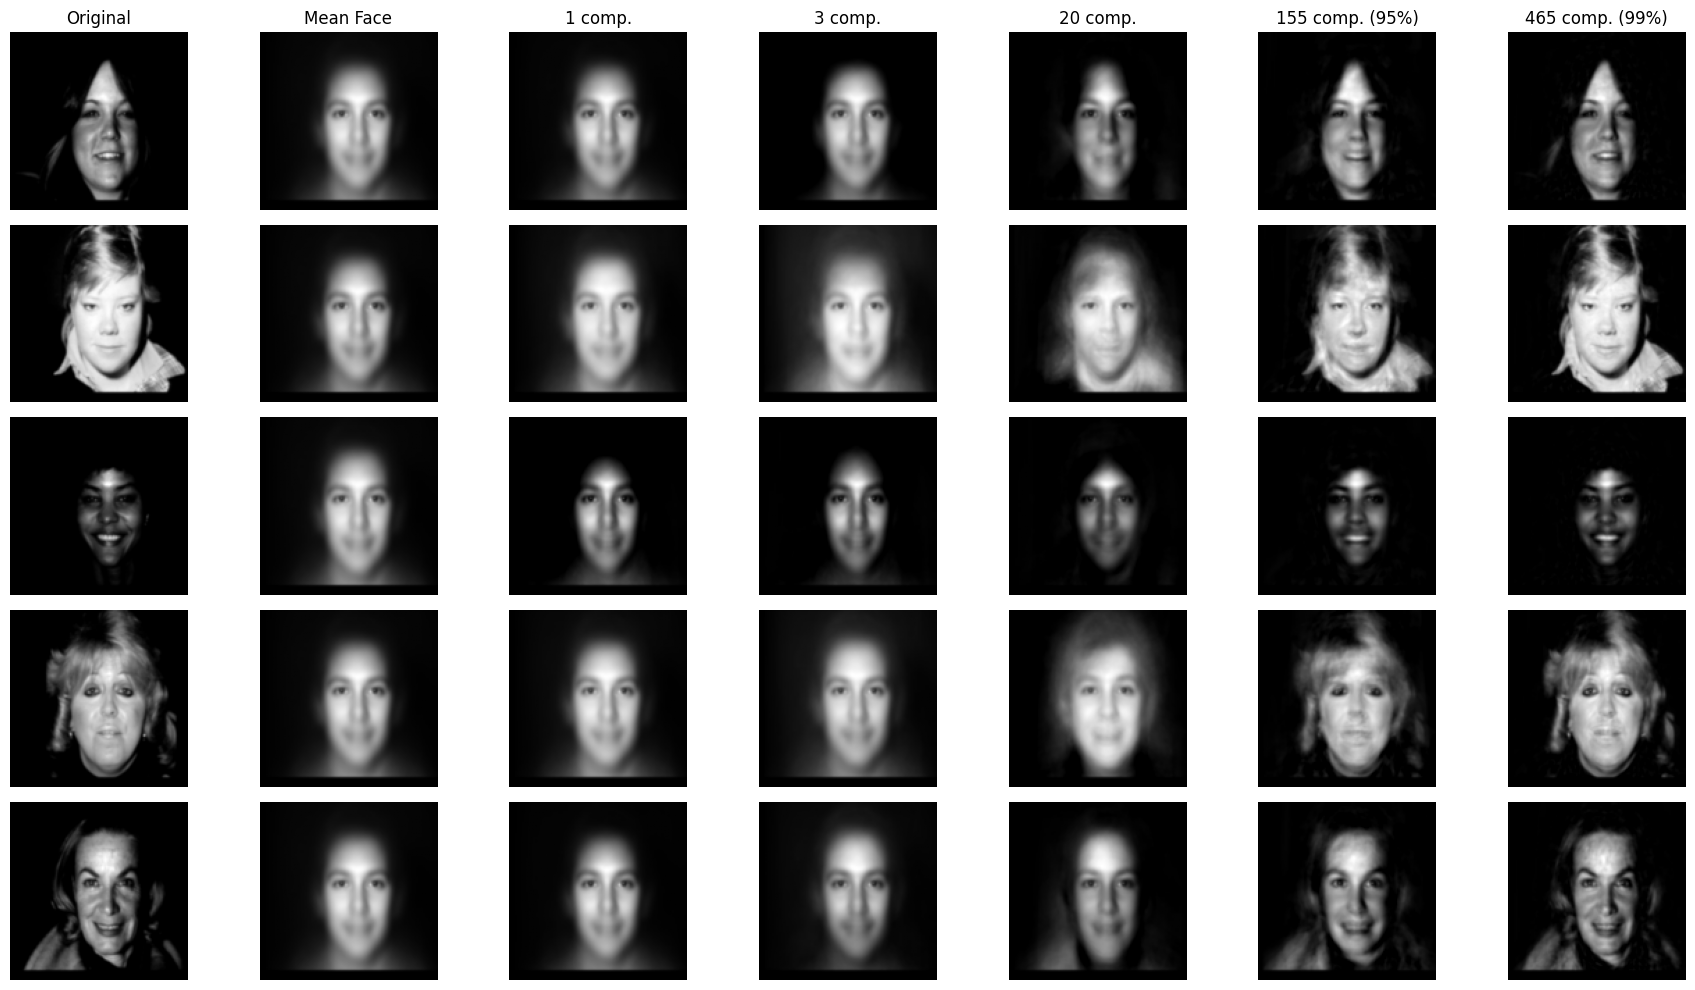

In [63]:
# Función para reconstruir imágenes con diferentes números de componentes
def reconstruir_imagenes(pca, imagenes_centradas, mean_face, n_componentes):
    proyeccion = pca.transform(imagenes_centradas)
    proyeccion[:, n_componentes:] = 0
    reconstruidas = pca.inverse_transform(proyeccion) + mean_face  # Reconstruir imágenes
    return np.clip(reconstruidas, 0, 255)

#primeras 5 imágenes
imagenes_mostrar = imagenes[:5]

# Reconstrucciones con diferentes números de componentes
reconstrucciones = [
    imagenes_mostrar,
    np.tile(mean_face, (5, 1)),
    reconstruir_imagenes(pca, imagenes_centradas[:5], mean_face, 1),
    reconstruir_imagenes(pca, imagenes_centradas[:5], mean_face, 3),
    reconstruir_imagenes(pca, imagenes_centradas[:5], mean_face, 20),
    reconstruir_imagenes(pca, imagenes_centradas[:5], mean_face, n_95),
    reconstruir_imagenes(pca, imagenes_centradas[:5], mean_face, n_99)
]

titulos = ["Original", "Mean Face", "1 comp.", "3 comp.", "20 comp.", f"{n_95} comp. (95%)", f"{n_99} comp. (99%)"]

# Graficar los resultados
fig, axes = plt.subplots(nrows=5, ncols=len(titulos), figsize=(18, 10))

for j in range(5):  # Iterar sobre las 5 imágenes
    for i, (titulo, imagen_set) in enumerate(zip(titulos, reconstrucciones)):
        img = imagen_set[j].reshape(128, 128)
        axes[j, i].imshow(img, cmap="gray")
        axes[j, i].axis("off")
        if j == 0:
            axes[j, i].set_title(titulo, fontsize=12)

plt.tight_layout()
plt.show()

¿Qué se puede concluir?

Como ya sabíamos desde clase, esto reduce la dimensión,  pero casi no pierde información, lo que provoca que visualmente a mí vista las imagenes tengan la misma calidad que la original, pero eso sí, las imágenes con la primera componente si sufren ya que pareciese ser un poco más borrosa, pero según la teoría debería:

1. Reducción de Dimensionalidad: PCA es una herramienta poderosa para la reducción de dimensionalidad, permitiendo representar datos de alta dimensión con un número reducido de componentes sin perder mucha información.
2. Compromiso entre Complejidad y Precisión: Hay un compromiso entre la cantidad de componentes utilizados y la precisión de la reconstrucción. Utilizar más componentes mejora la precisión, pero también aumenta la complejidad del modelo.
3. Eficiencia: Para muchas aplicaciones, utilizar un número de componentes que explique el 95% de la varianza puede ser suficiente, proporcionando un buen equilibrio entre eficiencia y precisión.

In [64]:
testing = [3037,1760,4212,1552,4020,3205,4444,3661,2581,3453,1304,4676,2924,2118,4815,4029,3802,1769,2588,
              1903,3668,2127,2315,1590,5130,2771,4486,3491,2543,3657,2785,4472,1332,4640,3465,1756,4224,3001,3233,
              1564,4016,1904,4678,3805,3039,4812,2923,5108,2749,3234,1563,4011,1751,4223,3006,1335,4647,3462,3650,
              2782,4475,3496,2544,2776,4481,2312,1597,5137,2120,2180,3052,4277,1705,4045,5197,4879,1537,3260,4421,
              3604,3436,4613,1361,2722,2510,1395,2174,2948,4283,5163,2346,3294,3409,1950,4846,1508,4248,2983,3851,
              2379,3099,2977,5164,2341,3293,2173,4284,2517,1392,2725,3431,4614,1366,1968,4426,3603,4042,5190,1530,
              3267,2187,3055,3869,4270,1702,2528,2970,4089,2984,3856,3258,4841,1957,4419,1359,2521,2713,2377,5152,
              4080,3097,2145,2979,3251,2383,4074,1506,4848,4246,1734,3063,4622,1350,3407,3635,4410,3894,2946,4883,
              2348,1995,1961,3438,3860,4279,5199,1539,4877,3632,4417,1959,4625,1357,3400,4241,1733,3064,3858,3256,
              2384,4073,1501,3090,2142,2370,5155,4087,2714,2526,4870,3269,2189,3867,1368,4428,1966,2519,1992,4884,
              3893,2941,5018,2833,2659,4768,1814,4902,3915,3129,2666,4591,2454,3586,5215,2030,2202,1487,5027,1641,
              4333,3116,3324,1473,4101,2692,3740,4565,1225,4757,3572,3912,1679,4905,4139,1813,3778,2498,2834,2008,
              4750,3575,2695,3747,4562,3323,1474,4106,1646,4334,3111,2205,1480,5020,5212,2037,2453,3581,2661,4596,
              1825,4759,3924,3118,4933,2802,1489,5029,2668,3588,1442,4130,3315,3127,1670,4302,3543,2491,4766,4554,
              3771,2465,4792,3785,2657,5016,2233,2001,1684,4598,2805,2039,4934,4108,1648,3923,3749,1822,2006,1683,
              5011]

def cargar_imagenes_binarias(ruta, nombres):
    """Carga imágenes binarias verificando que los archivos existan y muestra cuántos faltan."""
    nombres_validos = [n for n in nombres if os.path.exists(os.path.join(ruta, str(n)))]
    nombres_faltantes = set(nombres) - set(nombres_validos)

    if nombres_faltantes:
        print(f"{len(nombres_faltantes)} archivos no encontrados en '{ruta}'.")

    return np.array([
        np.frombuffer(open(os.path.join(ruta, str(n)), "rb").read(), dtype=np.uint8)
        for n in nombres_validos
    ]), nombres_validos

ruta_imagenes = "data/faces/rawdata"

# Filtrar imágenes existentes
Te, testing_faces_valid = cargar_imagenes_binarias(ruta_imagenes, testing)

print(f"Cargadas {len(Te)} de {len(testing)} imágenes de testing.")

# Aplicar PCA (solo con el modelo entrenado en training)
Te_proj = pca.transform(Te)

# Obtener la primera componente principal
first_comps = Te_proj[:, 0]

# Verificar que los datos sean del mismo tamaño
assert len(testing_faces_valid) == len(first_comps), "Error: Diferente número de etiquetas y componentes."

# Guardar el CSV con la primera componente de testing
output = pd.DataFrame({
    'id': testing_faces_valid,
    'label': first_comps
})

output.to_csv('PCA_Kevin_Murcia.csv', index=False)
print("PCA_Kevin_Murcia.csv generado correctamente.")


Cargadas 300 de 300 imágenes de testing.
PCA_Kevin_Murcia.csv generado correctamente.


In [65]:
# Descargar el archivo
files.download("PCA_Kevin_Murcia.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Punto 5

Utilizando el dataset del [amazon](https://github.com/jdramirez/UCO_ML_AI/blob/bf4036cf62b1b620a1ab1dade46361941ee1b8f0/src/notebook_class/supervisado/data/amazon_product.csv) data/amazon_products.csv crear: Utilizar la
librería de plotly.

In [2]:
#Subir el archivo a google colab
from google.colab import files
uploaded = files.upload()

Saving amazon_product.csv to amazon_product.csv


In [4]:
#leer el archivo
dfa = pd.read_csv('amazon_product.csv')

##5.1 Distribución de cada variables:

In [5]:
#variables categoricas y numericas
numerical_cols = ["product_price","product_original_price","product_star_rating","product_num_ratings","product_num_offers","product_minimum_offer_price","sales_volume","unit_price","unit_count"]
categorical_cols = ["currency","is_best_seller","is_amazon_choice","is_prime","climate_pledge_friendly","has_variations"]

def sanitize_sales_volume(value):
    match = re.search(r'(\d+(?:\.\d+)?)(K?)\+?', str(value))
    if match:
        num = float(match.group(1))
        if match.group(2) == "K":
            num *= 1000
        return num
    return 0

dfa["sales_volume"] = dfa["sales_volume"].apply(sanitize_sales_volume)
cols_to_clean = ["product_price", "product_original_price", "product_minimum_offer_price", "unit_price"]
for col in cols_to_clean:
    dfa[col] = pd.to_numeric(dfa[col].astype(str).str.replace(r'[^\d.]', '', regex=True), errors='coerce').fillna(0)

###5.1.1 Para las variables categóricas un gráfico de barras. Categoría numero de observaciones.

In [6]:
#grafico de barras variables categoricas
for col in categorical_cols:
    fig = px.bar(dfa[col].value_counts().reset_index(), x=dfa[col].value_counts().index, y=dfa[col].value_counts().values,
             labels={'x': col, 'y': 'Cantidad'}, title=f"Distribución de {col}")
    fig.show()

###5.1.2. Para las variables numéricas crear histogramas. Listar los productos que están más lejos de 5 estándares de desviación, y serían considerados outliers. Hacer test de si es una distribución normal o no.

In [7]:
#histograma variables numericas
for col in numerical_cols:
    fig = px.histogram(dfa, x=col, title=f"Histograma de {col}", nbins=30)
    fig.show()

In [8]:
# Identificar outliers (más de 5 desviaciones estándar)
for col in numerical_cols:
    mean, std = dfa[col].mean(), dfa[col].std()
    outliers = dfa[np.abs(dfa[col] - mean) > 5 * std][["asin", col]]
    if not outliers.empty:
        print(f"Outliers en {col}:\n", outliers.to_string(index=False), "\n", "-"*50)

Outliers en product_original_price:
       asin  product_original_price
B0CGTD5KVT                   699.0 
 --------------------------------------------------
Outliers en product_num_ratings:
       asin  product_num_ratings
B07Y8SJGCV              1015448 
 --------------------------------------------------
Outliers en sales_volume:
       asin  sales_volume
B0D5FZGY8W      100000.0 
 --------------------------------------------------
Outliers en unit_price:
       asin  unit_price
B0CS12LZLS        1.91
B0CV4FQPY1        2.05 
 --------------------------------------------------


In [9]:
# Test de normalidad
for col in numerical_cols:
    stat, p = shapiro(dfa[col].dropna())
    print(f"Test de Shapiro-Wilk para {col}: p-value = {p}")
    if p < 0.05:
        print("  -> No es normal\n")
    else:
        print("  -> Normal\n")

Test de Shapiro-Wilk para product_price: p-value = 1.5730304224688095e-11
  -> No es normal

Test de Shapiro-Wilk para product_original_price: p-value = 2.0741459881388515e-13
  -> No es normal

Test de Shapiro-Wilk para product_star_rating: p-value = 1.698422200534686e-07
  -> No es normal

Test de Shapiro-Wilk para product_num_ratings: p-value = 4.928942717743817e-15
  -> No es normal

Test de Shapiro-Wilk para product_num_offers: p-value = 8.13206839911081e-13
  -> No es normal

Test de Shapiro-Wilk para product_minimum_offer_price: p-value = 4.5808919809974e-11
  -> No es normal

Test de Shapiro-Wilk para sales_volume: p-value = 2.5402611702157832e-14
  -> No es normal

Test de Shapiro-Wilk para unit_price: p-value = 1.8278396662199933e-16
  -> No es normal

Test de Shapiro-Wilk para unit_count: p-value = 0.0067438087882866465
  -> No es normal



##5.2 Gráfico de la relación de cada variable con respecto al sales_volume (convertir a numero):

###5.2.1. Variables categóricas debes crear un boxplot. Explique cómo interpreta el gráfico

In [10]:
#Boxplots para variables categóricas respecto a sales_volume
for col in categorical_cols:
    fig = px.box(dfa, x=col, y="sales_volume", title=f"Boxplot de {col} vs Sales Volume")
    fig.show()

Al analizar las diferentes categorías de productos, es posible identificar cuáles mantienen volúmenes de ventas más altos y estables. Esto sugiere que ciertos atributos, como ser un producto ecológico o contar con la distinción de Amazon Choice, pueden estar relacionados con un mejor desempeño en ventas, ya sea impulsando la demanda o reduciendo la variabilidad en los ingresos.

###5.2.2 Variables numéricas vas a crear un scatter plot.Explique cómo interpreta el gráfico



In [11]:
#Scatter plots para variables numéricas respecto a sales_volume
for col in numerical_cols:
    if col != "sales_volume":
        fig = px.scatter(dfa, x=col, y="sales_volume", title=f"Scatter plot de {col} vs Sales Volume")
        fig.show()

Al analizar el gráfico, se puede determinar si existe una tendencia en la que un menor valor en las variables numéricas está asociado con un mayor volumen de ventas.

##5.3 Matriz de correlación

##5.3.1 Cree la matriz de correlación, cuales son las variables más importantes para explicar la variabilidad de las sales_volume. Explique por qué el coeficiente es negativo o positivo.

In [12]:
#Matriz de correlación
correlation_matrix = dfa[numerical_cols].corr()
fig = px.imshow(correlation_matrix, text_auto=True, title="Matriz de Correlación")
fig.show()
correlation_with_sales = correlation_matrix["sales_volume"].drop("sales_volume").sort_values(ascending=False)
print("Variables más importantes para sales_volume:")
print(correlation_with_sales)

Variables más importantes para sales_volume:
unit_count                     0.971612
unit_price                     0.569519
product_star_rating            0.188771
product_original_price        -0.000812
product_minimum_offer_price   -0.029923
product_price                 -0.039118
product_num_ratings           -0.083361
product_num_offers            -0.101282
Name: sales_volume, dtype: float64


Las variables más influyentes en el volumen de ventas son unit_count y unit_price, con correlaciones positivas, indicando que mayores cantidades y precios unitarios impulsan las ventas. En contraste, variables como product_price y product_num_offers tienen correlaciones negativas, sugiriendo que precios elevados y más ofertas pueden reducir la demanda.

###5.3.2 Cree las dummy variables para todas las variables categóricas y genere la matriz de correlación nuevamente. ¿Cuál es el valor de variable categórica con mayor correlación?

In [13]:
# Crear variables dummy
df_dummies = pd.get_dummies(dfa[categorical_cols].drop(columns=["currency"]))
correlation_matrix_dummies = df_dummies.corr()
fig = px.imshow(correlation_matrix_dummies, text_auto=True, title="Matriz de Correlación con Dummies")
fig.show()

la variable categórica con mayor correlación es "climate_pledge_friendly" con "has_variations" (0.335578). Esto sugiere que los productos ecológicos tienden a presentar más variaciones en sus modelos u opciones.

###5.3.3 Utilizar python para imputar los valores nulos con la media. Después dividir los datos en train y test. Por ultimo hacer una regresión entre x que es product_num_ratings y y product_star_rating qué es la calificación. Cual es el coeficiente b1 y b0.  Describir resultados.

In [18]:
# Seleccionar variables
X = dfa[["product_num_ratings"]]
y = dfa["product_star_rating"]

# Imputar valores nulos con la media
imputer = SimpleImputer(strategy="mean")
X = imputer.fit_transform(X)
y = imputer.fit_transform(y.values.reshape(-1, 1)).ravel()

# Dividir en train y test (80% - 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear y entrenar el modelo de regresión
model = LinearRegression()
model.fit(X_train, y_train)

# Obtener coeficientes
b0 = model.intercept_
b1 = model.coef_[0]

print(f"Coeficiente b0 (intercepto): {b0:.4f}")
print(f"Coeficiente b1 (pendiente): {b1:.4f}")

Coeficiente b0 (intercepto): 4.2559
Coeficiente b1 (pendiente): 0.0000


La línea de regresión, entrenada con el 80% de los datos, predice con precisión los valores del conjunto de prueba. Los datos de testing siguen la tendencia del modelo, lo que demuestra su buen desempeño y capacidad de generalización.